In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.tabular import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

# Real process

This is a Kaggle competition to estimate the sale of eaceh Rossmann store. Details are in: https://www.kaggle.com/c/rossmann-store-sales/data 



In [5]:
path = Path('data/rossmann/')
train_df = pd.read_pickle(path/'train_clean')

## Cleaned data

One important step is `add_datepart`

```python
add_datepart(train, "Date", drop=False)
```

In [6]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [7]:
n = len(train_df); n

844338

## Small training set

In [8]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()    # sort by index

small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [9]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
322,324,5,"Jan,Apr,Jul,Oct",13140.0,55,7753
369,371,5,"Feb,May,Aug,Nov",1970.0,54,8360
782,784,5,"Jan,Apr,Jul,Oct",560.0,61,9284
877,880,5,NaN,4570.0,51,10670
956,959,5,NaN,1060.0,61,10708


In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
417450,1108,6,NaN,540.0,85,2400
417774,318,5,NaN,32330.0,75,8157
418500,1045,5,NaN,26990.0,78,7227
418924,355,4,NaN,9720.0,83,10066
421038,242,2,"Jan,Apr,Jul,Oct",6880.0,53,4775


In [11]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [12]:
small_train_df.columns

Index(['Store', 'DayOfWeek', 'PromoInterval', 'CompetitionDistance',
       'Mean_Humidity', 'Sales'],
      dtype='object')

In [13]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
417450,NaN,6,NaN,540.0,85,2400
417774,318.0,5,NaN,32330.0,75,8157
418500,NaN,5,NaN,26990.0,78,7227
418924,NaN,4,NaN,9720.0,83,10066
421038,242.0,2,"Jan,Apr,Jul,Oct",6880.0,53,4775


#### Note: 
PromoInterval is a category but show up as a list in `head()`. They are represented as One-hot-encoding

In [14]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [15]:
small_train_df['PromoInterval'].cat.codes[:5]  # based on index

322    1
369    0
782    1
877   -1
956   -1
dtype: int8

In [16]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [17]:
small_train_df.columns

Index(['Store', 'DayOfWeek', 'PromoInterval', 'CompetitionDistance',
       'Mean_Humidity', 'Sales', 'CompetitionDistance_na'],
      dtype='object')

In [18]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
5887,291,6,NaN,2470.0,55,4132,True
168143,879,6,"Feb,May,Aug,Nov",2470.0,82,3842,True


Before moving on...

In [19]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
322,324,5,"Jan,Apr,Jul,Oct",13140.0,55,7753,False
369,371,5,"Feb,May,Aug,Nov",1970.0,54,8360,False
782,784,5,"Jan,Apr,Jul,Oct",560.0,61,9284,False
877,880,5,NaN,4570.0,51,10670,False
956,959,5,NaN,1060.0,61,10708,False


# Full dataset

In [20]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [21]:
len(train_df),len(test_df)

(844338, 41088)

In [22]:
procs=[FillMissing, Categorify, Normalize]

In [23]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [24]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [25]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [26]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [27]:
valid_idx = range(cut)

In [28]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [29]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [30]:
doc(FloatList)

# Model

In [31]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [32]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [33]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [34]:
data.train_ds.cont_names

['CompetitionDistance',
 'Max_TemperatureC',
 'Mean_TemperatureC',
 'Min_TemperatureC',
 'Max_Humidity',
 'Mean_Humidity',
 'Min_Humidity',
 'Max_Wind_SpeedKm_h',
 'Mean_Wind_SpeedKm_h',
 'CloudCover',
 'trend',
 'trend_DE',
 'AfterStateHoliday',
 'BeforeStateHoliday',
 'Promo',
 'SchoolHoliday']

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


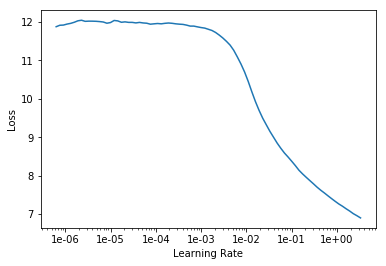

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.038972,0.039573,0.168319,01:19
1,0.043153,0.067948,0.310643,01:16
2,0.033758,0.063840,0.212221,01:16
3,0.022515,0.023096,0.143586,01:23
4,0.013264,0.014526,0.114958,01:22


In [37]:
learn.save('1')

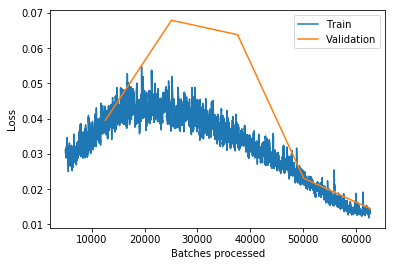

In [39]:
learn.recorder.plot_losses(skip_start=5000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


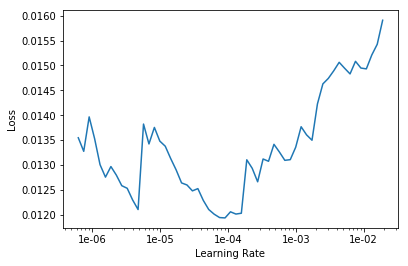

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013283,0.014832,0.115681,01:16
1,0.013671,0.015138,0.117116,01:22
2,0.012208,0.013206,0.112883,01:22
3,0.011097,0.013510,0.110656,01:22
4,0.011691,0.013610,0.111551,01:22


In [42]:
learn.fit_one_cycle(5, 2e-5)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.009801,0.015083,0.115621,01:22
1,0.011351,0.014494,0.113540,01:21
2,0.010644,0.014746,0.113257,01:22
3,0.011359,0.015124,0.114206,01:17
4,0.010392,0.014873,0.114651,01:18


In [43]:
learn.save('2')

In [ ]:
learn.load('2')

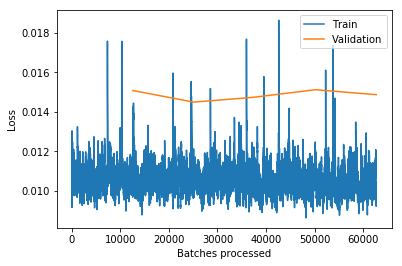

In [44]:
learn.recorder.plot_losses()